# Principal Component Analysis (PCA)

Similar to feature selection, we can use feature extraction to reduce the number of features in a dataset. However, while feature selection algorithms maintain the original features used,  feature extraction transforms or projects the data onto a new feature space. In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant  information. Feature extraction is typically used to improve computational efficiency but can also help to reduce the curse of dimensionality—especially if we are working with nonregularized models. 

Principal component analysis (PCA) is an unsupervised linear transformation technique that is primarily used for dimensionality reduction. PCA helps us to identify patterns in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance given the constraint that the new feature axes are orthogonal to each other as illustrated in the following figure. Here, 1 x and 2 x are the original feature axes, and PC1 and PC2 are the principal components:
![alt](extras/05_01.png)

PCA takes data and identifies the linear line (eigenvector) through the data that best captures your variance (a high eigenvalue) (note: this linear line can be in any n-dimensional space). This can be thought of much like linear regression where the eigenvector is a linear equation incorporating n dimensions. Each eigenvector has an eigenvalue - the "spread" / "importance" value. This tells you: how important is this axis (eigenvector)?; which axis aligns best with the data? The eigenvector with the highest eigenvalue is your first principal component (pc1; this would be the linear-regression-like line). 

The number of eigenvectors is always equal to the number of dimensions in your data. So, if your data is 2D, your will have an eigenvector (pc2) that's orthogonal to pc1. If it's 3D, you will have two additional eigenvectors that are orthogonal to pc1 (pc2 and pc3). Each eigenvector is ranked based on how much of the variance in the data it captures (as measured by the eigenvalue).

PCA is an unsupervised method, which means that information about the class labels is ignored.

PCA is used on numerical features, not categorical ones. There are so-called Nonlinear PCAs (or Categorical PCAs), however it's unclear if these are tested enough. One should not use PCA when the variance cannot be explained by the top handful of PCs. If your first eigenvector explains very little of the variance, you're not gaining anything through PCA.

## Calculating the Principal Components Manually

The approach can be summarized in these six steps.  

1. Standardize the d-dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Select k eigenvectors that correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace ( k  d ).
5. Construct a projection matrix W from the "top" k eigenvectors.
6. Transform the d -dimensional input dataset X using the projection matrix W to obtain the new k -dimensional feature subspace.

Let us now run through these steps using the Boston housing dataset. 

In [1]:
from sklearn import datasets
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Retrieve the data.

In [2]:
boston = datasets.load_boston()
X = pd.DataFrame(boston['data'], columns=boston['feature_names'])
del X['CHAS']
y = pd.Series(boston['target'], name='MED')
bos = pd.concat([y, X], axis=1)

Split into train and test data.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

1 - Standardize the d -dimensional dataset.

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

2 - Construct the covariance matrix.  

The symmetric d × d -dimensional covariance matrix, where d is the number of dimensions in the dataset, stores the pairwise covariances between the different features.

In [5]:
import numpy as np
cov_mat = np.cov(X_train_std.T)

In [7]:
cov_mat.shape

(12L, 12L)

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude.

3 - Decompose the covariance matrix into its eigenvectors and eigenvalues.

In [8]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)
eigen_vecs[:,0]


Eigenvalues 
[ 6.03057201  1.34336365  1.25872911  0.86153506  0.69415833  0.55743786
  0.38513974  0.06421224  0.28844304  0.20646215  0.180502    0.16343914]


array([-0.23967058,  0.26451752, -0.34796603, -0.34890578,  0.18959303,
       -0.31798919,  0.32036802, -0.31615825, -0.3398736 , -0.20138902,
        0.19157075, -0.31200576])

4 - Select k eigenvectors that correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace ( k  d ).

In [9]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In the chart below, we can see that that first principal component explains up to 50% of the variance in the data. The variance explained ratio is simply the fraction of an eigenvalue and the total sum of all the eigenvalues (see calculation above).

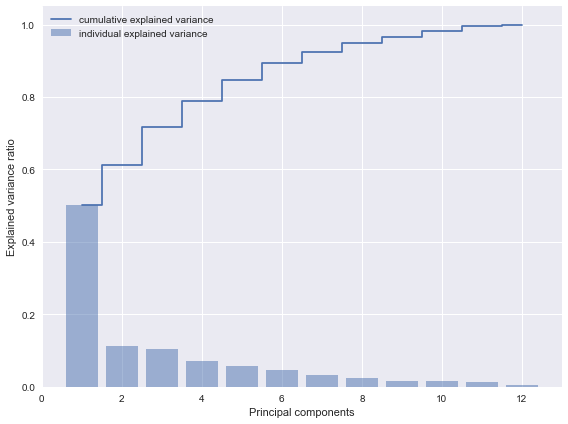

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,6))
plt.bar(range(1, 13), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 13), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Note: I added the `key=lambda k: k[0]` in the sort call above
# just like I used it further below in the LDA section.
# This is to avoid problems if there are ties in the eigenvalue
# arrays (i.e., the sorting algorithm will only regard the
# first element of the tuples, now).


5 - Construct a projection matrix W from the "top" k eigenvectors.

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

('Matrix W:\n', array([[-0.23967058, -0.38570112],
       [ 0.26451752, -0.4133604 ],
       [-0.34796603,  0.08460214],
       [-0.34890578,  0.1515204 ],
       [ 0.18959303, -0.03146719],
       [-0.31798919,  0.33873475],
       [ 0.32036802, -0.35839171],
       [-0.31615825, -0.40035267],
       [-0.3398736 , -0.33098002],
       [-0.20138902, -0.2176333 ],
       [ 0.19157075,  0.29570451],
       [-0.31200576,  0.03795251]]))


In [13]:
w.shape

(12L, 2L)

In [14]:
X_train_std.shape

(354L, 12L)

6 - Transform the d -dimensional input dataset X using the projection matrix W to obtain the new k -dimensional feature subspace.

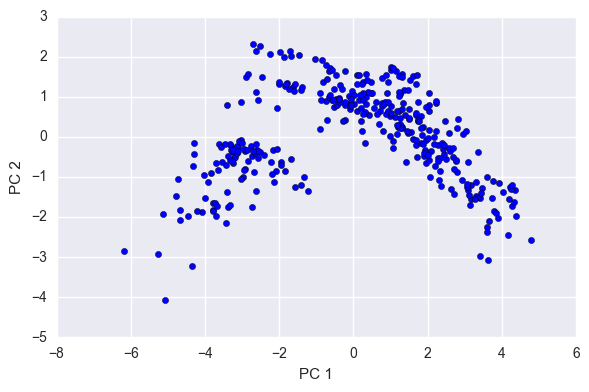

In [34]:
X_train_pca = X_train_std.dot(w)

plt.scatter(X_train_pca[:, 0], 
                X_train_pca[:, 1])

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## PCA in Scikit-Learn

In [35]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.50112804,  0.11163074,  0.10459778,  0.07159178,  0.05768312,
        0.04632193,  0.03200431,  0.02396902,  0.01715658,  0.01499934,
        0.01358145,  0.0053359 ])

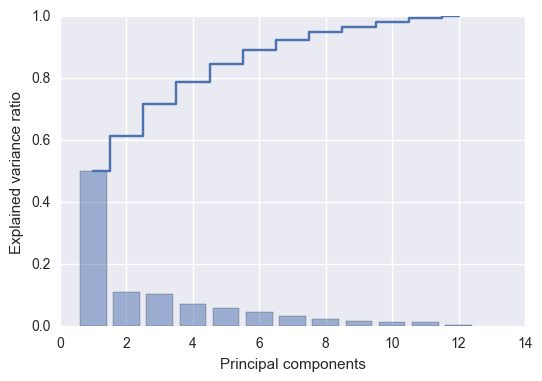

In [36]:
plt.bar(range(1, 13), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 13), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In scikit-learn, we must use the fit-transform process to obtain the obtain our principal components from out dataset.  

_Note_: we must be careful to only fit against the training data. 

In [37]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Below, if we compare the PCA projection via scikit-learn with our own PCA implementation, we notice that the plot above is a mirror image of the previous PCA via our step-by-step approach. Note that this is not due to an error in any of those two implementations, but the reason for this difference is that, depending on the eigensolver, eigenvectors can have either negative or positive signs. Not that it matters, but we could simply revert the mirror image by multiplying the data with -1 if we wanted to; note that eigenvectors are typically scaled to unit length 1.

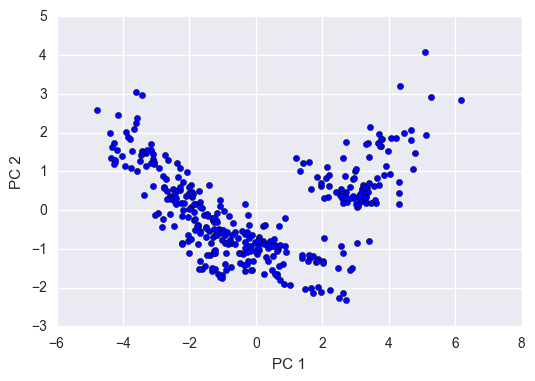

In [38]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [ ]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

## References
- https://en.wikipedia.org/wiki/Principal_component_analysis
- Raschka, Sebastian. _Python Machine Learning_. Packt Publishing, 2015, Birmingham, UK.